In [162]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from modules import preprocess
from matplotlib import pyplot as plt

number_to_month = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "june", 7: "july", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"} 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
# USER INPUTS
ecmwf_country = "BR" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, test_years = preprocess.get_study_metadata(ecmwf_country, crop)

print(crop, ecmwf_country, crop_season_in_days_of_year, crop_season_in_months, test_years)

wheat BR (129, 329) (5, 11) [2006, 2015, 2017]


In [178]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
crop_calendar = pd.read_csv("../data/CY-Bench/{}/{}/crop_calendar_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path)
country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]

### Figures

In [291]:
crop_production_harvested_area = yield_data.loc[yield_data["harvest_year"].between(2003,2022)].groupby("adm_id")[["production", "harvested_area"]].mean().reset_index()
crop_production_harvested_area["production"] = crop_production_harvested_area["production"] / 1e6
crop_production_harvested_area["harvested_area"] = crop_production_harvested_area["harvested_area"] / 1e6

In [292]:
adm1_level = country_gpd.dissolve(by="ADM1_PT").to_crs("EPSG:4326").reset_index()[["ADM1_PT", "geometry"]]
country_gpd_crop = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
adm1_level_crop_calendar = gpd.GeoDataFrame(crop_calendar.merge(country_gpd_crop, on="adm_id")).dissolve(by="ADM1_PT", aggfunc={"sos": "mean", "eos": "mean"}).to_crs("EPSG:4326").reset_index()
adm1_level_crop_production = gpd.GeoDataFrame(crop_production_harvested_area.merge(country_gpd_crop, on="adm_id")).dissolve(by="ADM1_PT", aggfunc={"production": "sum", "harvested_area":"sum"}).to_crs("EPSG:4326").reset_index()
adm1_level_crop = gpd.GeoDataFrame(adm1_level_crop_calendar.merge(adm1_level_crop_production.drop("geometry", axis=1), on="ADM1_PT")).to_crs("EPSG:4326").reset_index()

crop_calendar_info_map = gpd.GeoDataFrame(adm1_level.merge(adm1_level_crop[["ADM1_PT", "sos", "eos", "production", "harvested_area"]], on="ADM1_PT"))
crop_calendar_info_map = crop_calendar_info_map.assign(length=crop_calendar_info_map["eos"] - crop_calendar_info_map["sos"],
                                                       intensity=crop_calendar_info_map["harvested_area"]/crop_calendar_info_map["geometry"].to_crs(epsg=32723).area)

In [293]:
crop_calendar_info_map["production"] = crop_calendar_info_map["production"] / 1e6
crop_calendar_info_map["harvested_area"] = crop_calendar_info_map["harvested_area"] / 1e6

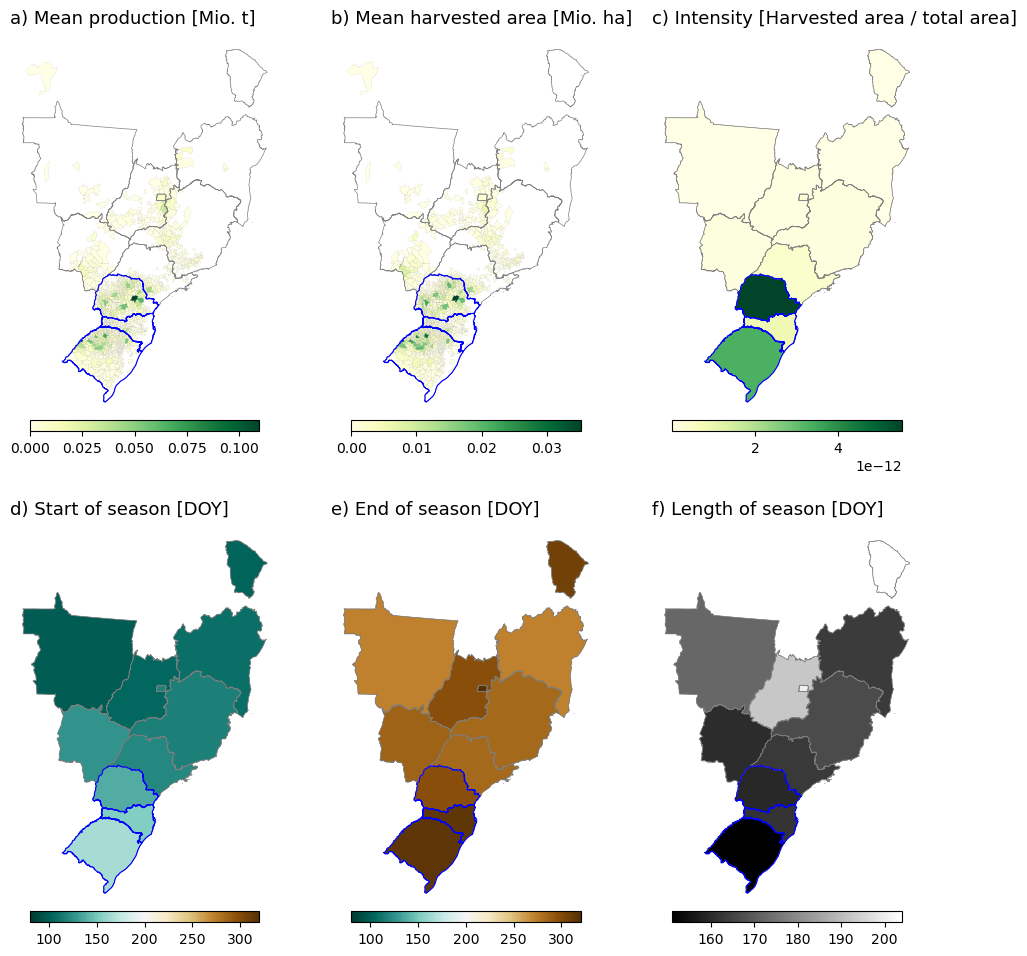

In [299]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.ravel()

adm2_crop_data = gpd.GeoDataFrame(crop_production_harvested_area.merge(country_gpd_crop, on="adm_id")).to_crs("EPSG:4326")

# a) Production by adm2
adm2_crop_data.plot(ax=axs[0], column="production", legend=True, edgecolor="grey", linewidth=.05, cmap="YlGn", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[0].set_title("a) Mean production [Mio. t]", loc="left", fontsize=13)

# b) Harvested area by adm2
adm2_crop_data.plot(ax=axs[1], column="harvested_area", legend=True, edgecolor="grey", linewidth=.05, cmap="YlGn", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[1].set_title("b) Mean harvested area [Mio. ha]", loc="left", fontsize=13)

# c) Harvested area intensity by adm1
crop_calendar_info_map.plot(column="intensity", legend=True, edgecolor="black", linewidth=.1, cmap="YlGn", ax=axs[2], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[2].set_title("c) Intensity [Harvested area / total area]", loc="left", fontsize=13)

# d) Start of season by adm1
crop_calendar_info_map.plot(column="sos", legend=True, edgecolor="black", linewidth=.1, vmin=80, vmax=320, cmap="BrBG_r", ax=axs[3], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [100, 150, 200, 250, 300]})
axs[3].set_title("d) Start of season [DOY]", loc="left", fontsize=13)

# e) End of season by adm1
crop_calendar_info_map.plot(column="eos", legend=True, edgecolor="black", linewidth=.1, vmin=80, vmax=320, cmap="BrBG_r", ax=axs[4], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [100, 150, 200, 250, 300]})
axs[4].set_title("e) End of season [DOY]", loc="left", fontsize=13)

# f) Length of season by adm1
crop_calendar_info_map.plot(column="length", legend=True, edgecolor="black", linewidth=.1, ax=axs[5], cmap="gray", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [160, 170, 180, 190, 200]})
axs[5].set_title("f) Length of season [DOY]", loc="left", fontsize=13)

for ax in axs: 
    crop_calendar_info_map.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=.5)
    crop_calendar_info_map.loc[crop_calendar_info_map["ADM1_PT"].isin(["Rio Grande do Sul", "Paraná", "Santa Catarina"])].plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=.8)
    ax.axis("off")

plt.tight_layout()
plt.savefig("season_{}_{}.png".format(crop, ecmwf_country))
plt.show()